# PolarTEP eScience Lab:  Using XCube in Polar-TEP to Generate NDVI

## Introduction

This notebook uses the xcube function to call imagery into a cube, with the axis being lat, lon, and time. Each point within the cube has whatever bands you call into it. It has its pros and cons, as it certainly cannot do as much as the API but it is significantly easier to use and understand.

## Learning Objectives

By the end of the lab exercise, you should be able to:

* Use basic Markdown syntax 
* Import supporting code packages into your project
* Access PolarTEP data for analysis
* Create a multivariable data cube
* Visualize data
* Analyze data and generate new data (Normalized Difference Vegetation Index - NDVI)
* Creating ancillary data visualizations
* Exporting data for use on other platforms


## Required skills and prerequisites

To complete this tutorial you should have the following skills and tools:

* The latest version of a modern browser (e.g. Google Chrome, Mozilla Firefox, Microsoft Edge)
* A current PolarTEP account 
* Basic understanding of Python code
* Ability to use a Jupyter Notebook, including running code blocks
* Completion of introductory PolarTEP tutorials (Recommended)

## External References

[Markdown Getting Started](https://www.markdownguide.org/getting-started/)

[Python for Beginners](https://www.python.org/about/gettingstarted/)

[Jupyter Notebook documentation](https://docs.jupyter.org/en/latest/)

[Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)

## Importing supporting code packages into your project

Most projects will benefit from the use of existing code libraries or "packages" that add functionality to your application.  In this case, you will be creating a data cube, using data arrays, and other data manipulation and analysis utilties.  

In [42]:
from edc import check_compatibility
check_compatibility("user-2022.10-14", dependencies=["SH"])

#Packages 

# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.viewer import ViewerServer

# xcube imports
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

#import xarray as xr 
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
#import odc.geo.xr

# Various utilities
import json
from datetime import date, timedelta
import xarray as xr
import shapely.geometry
import IPython.display
import zarr
import numpy as np
import os



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


## Data Generation (Accessing PolarTEP data for analysis)

The first step in creating an application that analyzes data is to access data.  Using a data cube to generate an NDVI is inherhently a geospatial data analysis.  A study area or "bounding box" must first be defined.

In [43]:
#Creates bounding box, edit the coordinates to change the area
x1 = -134.67 # degrees, westmost point
y1 = 69.41  # degrees, southmost point
x2 = -134.54  # degrees, eastmost point
y2 = 69.50  # degrees, northmost point

bbox = x1, y1, x2, y2

An IPython function can be used to visualize your study area (bounding box)

In [ ]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

## Generate Cube (create a multivariate data cube)

First create the configurations required for the cube. This includes the data bands and dates.

More information on S2L2A and other SH functionalities: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/

In [44]:
spatial_res = 0.00018   # = 10.038 meters in degrees

time_range = ['2018-08-30','2018-09-30']
cube_config = CubeConfig(dataset_name = 'S2L2A', #Calls the Sentinel-2 L2A library
                         band_names = ['B02', 'B03', 'B04', 'B08'],
                         tile_size = [512, 512],
                         bbox = bbox,
                         spatial_res = spatial_res,
                         time_range = time_range,
                         time_period = '5D') #S2L2A has a revisit time of 5 days, so anything shorter would be redundant

Then create the cube. For computational efficiency the cube is created as a shell, and the data is called when required.

In [45]:
request_collector = Observers.request_collector() #Sends data to SH

#Create the actual cube containing 'lazy' data
cube = open_cube(cube_config, observer=request_collector)

## Visualize data from the cube

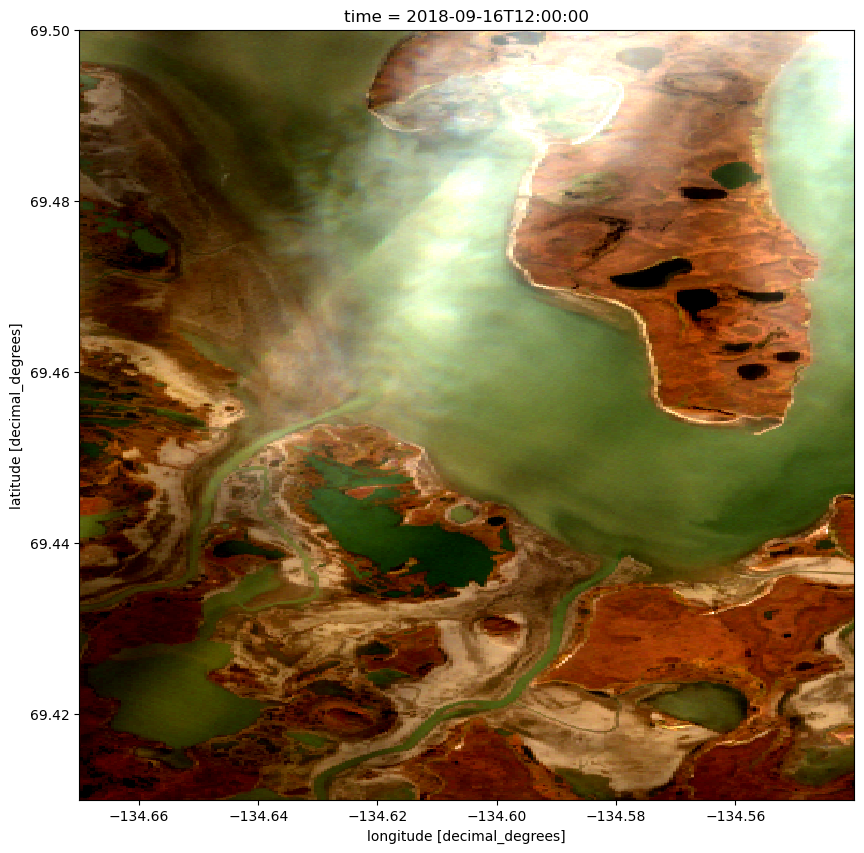

In [33]:
#Display RGB image of a single day
cube[['B04', 'B03', 'B02']].isel(time=3).to_array().plot.imshow(robust=True, figsize=(10,10))

# Analyze data and generate new data (Normalized Difference Vegetation Index - NDVI)

In [46]:
#Create NDVI variable and add it into the cube
ndvi=(cube.B08-cube.B04)/(cube.B08+cube.B04)

ndvi.attrs['long_name'] = 'Normalized Difference Vegetation Index'
ndvi.attrs['units'] = 'unitless'

cube['NDVI']=ndvi

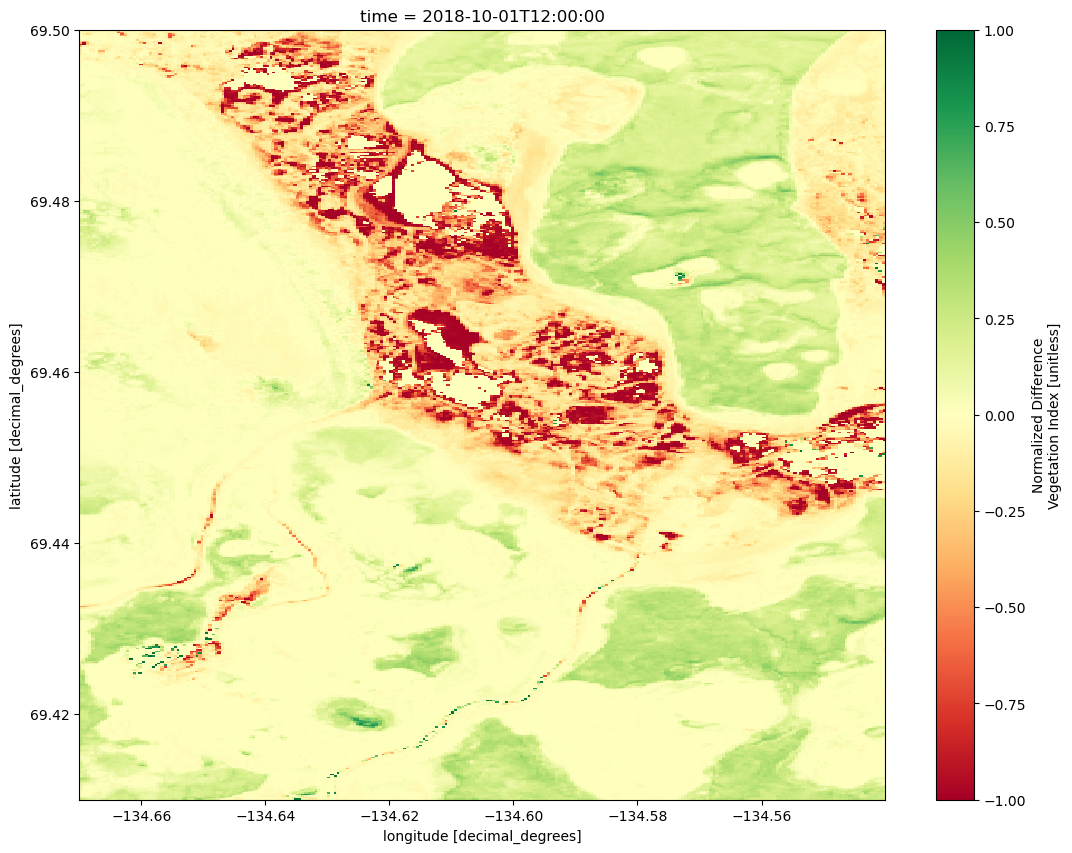

In [16]:
#Displaying NDVI from a single day
cube.NDVI.sel(time='2018-09-30', method='nearest').plot.imshow(vmin=-1, vmax=1, cmap='RdYlGn', figsize=(13, 10))

## Creating ancillary data visualizations (graphs and charts)

In [17]:
#Calculate the average using the x and y dimensions, so that it is done per day on the entire area
avg = cube.NDVI.mean(['lon', 'lat'])

#Check to ensure the formatting is correct
print(avg)

<xarray.DataArray 'NDVI' (time: 7)>
dask.array<mean_agg-aggregate, shape=(7,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-09-01T12:00:00 ... 2018-10-01T12:00:00


In [18]:
#Connect the NDVI value with the corrosponding date
timeseriesNDVI = avg.to_series()

#Check to ensure the transpose occured correctly
print(timeseriesNDVI)

time
2018-09-01 12:00:00    0.009137
2018-09-06 12:00:00    0.029070
2018-09-11 12:00:00    0.060464
2018-09-16 12:00:00   -0.030509
2018-09-21 12:00:00    0.016541
2018-09-26 12:00:00   -0.026812
2018-10-01 12:00:00   -0.022896
Name: NDVI, dtype: float32


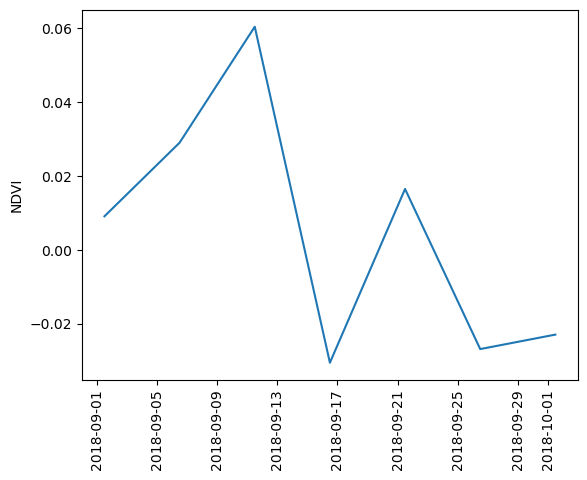

In [20]:
#Simple plot to visualize the average NDVI change over time
plt.plot(timeseriesNDVI)
plt.xticks(rotation='vertical')
plt.ylabel('NDVI')
plt.show()

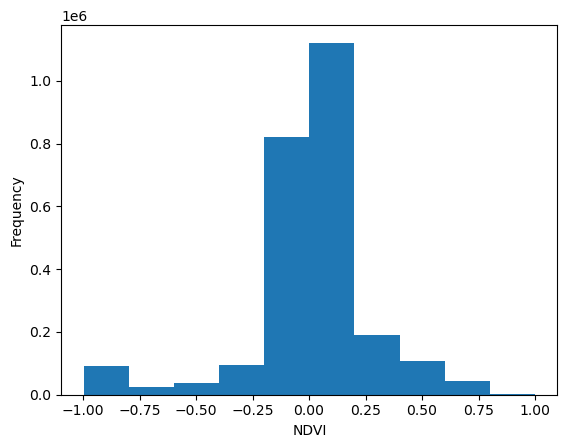

In [21]:
cube.NDVI.plot.hist()
plt.title('')
plt.ylabel('Frequency')
plt.xlabel('NDVI')
plt.show()

# Displaying all the dates

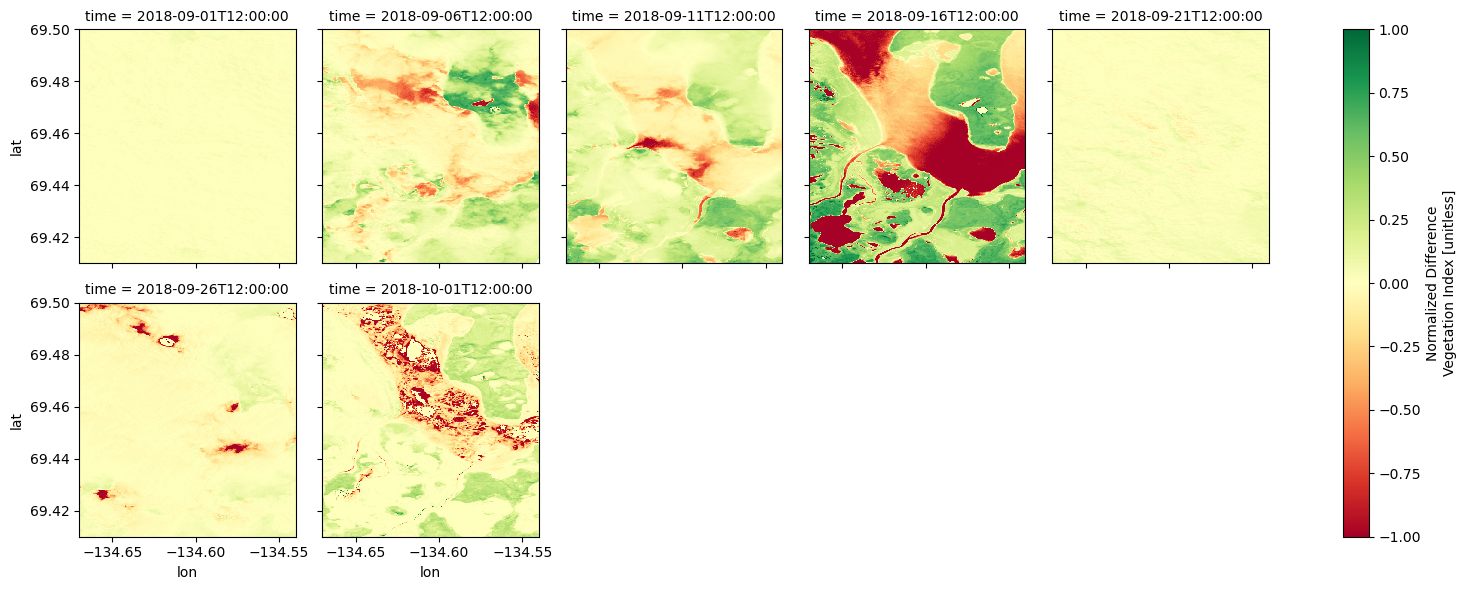

In [48]:
cube.NDVI.plot.imshow(col='time', col_wrap=5, vmin=-1, vmax=1,cmap='RdYlGn')

In [47]:
# SEEMS TO HAVE FIXED THE NAN ISSUE WHEN USING DIFFERENT DATA

for ndvi_date in cube.NDVI:
    print(
        {
            "date": str(ndvi_date.time.values),
            "max": ndvi_date.values.max(),
            "mean": ndvi_date.values.mean(),
            "min": ndvi_date.values.min(),
            "stDev": np.std(ndvi_date.values),
        }
    )

{'date': '2018-09-01T12:00:00.000000000', 'max': 0.10448063, 'mean': 0.009137163, 'min': -0.06061923, 'stDev': 0.012537325}
{'date': '2018-09-06T12:00:00.000000000', 'max': nan, 'mean': nan, 'min': nan, 'stDev': nan}
{'date': '2018-09-11T12:00:00.000000000', 'max': 0.9901478, 'mean': 0.060464177, 'min': -0.9923077, 'stDev': 0.20669918}
{'date': '2018-09-16T12:00:00.000000000', 'max': 0.99867284, 'mean': -0.030509043, 'min': -0.9957894, 'stDev': 0.5795754}
{'date': '2018-09-21T12:00:00.000000000', 'max': 0.241729, 'mean': 0.016541189, 'min': -0.2819034, 'stDev': 0.030107213}
{'date': '2018-09-26T12:00:00.000000000', 'max': 0.8571429, 'mean': -0.026812462, 'min': -0.99239546, 'stDev': 0.11204647}
{'date': '2018-10-01T12:00:00.000000000', 'max': 0.98529416, 'mean': -0.022895835, 'min': -0.99479157, 'stDev': 0.25248358}


# Discussion

Student discussion goes here.  Possibly using interactive learning and evaluation tools.

# Export data

In [31]:
cube.attrs['history'] = ''
cube.to_netcdf(path=os.path.expanduser("~/test.nc"), mode='w', format='NETCDF4')

# Quiz

- What are some limitations to the cube method?
    -- No cloud cover control, mosaicking is difficult and finicky, making it difficult to get the best possible image over a timeframe
    
- What are some of the benefits?
    -- Simple and easy to understand and manipulate. Can easily write to netCDF and put into GIS as a multilayer raster if you want to create better maps
    
- Calculate NDWI instead of NDVI, or other calculations within the actual cube



# Related Research

Ashok, A., Rani, H. P., & Jayakumar, K. V. (2021). Monitoring of dynamic wetland changes using NDVI and NDWI based landsat imagery. Remote Sensing Applications: Society and Environment, 23, 100547.

Oloyede, A. O., Olatunbosun, D. E., Asuquo, P. M., Udo, U. E., & Essien, I. O. (2021). Correlation Analysis of Vegetation and Land Surface Temperature in Uyo, Nigeria Using Satellite Remote Sensing and Python-Based Geographic Information System. Science and Technology Publishing, 5(2632-1017).

...
